# Домашнее задание №1

Темы "Введение в МатСтат" и "Виды статистических оценок и характеристики"

Общие положения:
- Макс кол-во баллов за ДЗ - 25 баллов
- Качество оформления и кода играет роль

Список заданий:
1. Посчитайте кол-во уникальных жанров. (1 балл)
2. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по типу аниме `type`. (1 балл)
3. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по жанрам `genre`. (1 балл)
4. Посчитайте и визуализируйте квартили Q1, Q2 и Q3 с интерквантильным размахом по жанрам `genre` и типу аниме `type`. (1 балл)
5. Насколько часто встречаются аниме с одним или двумя жанрами? (1 балл)
6. Сколько в среднем эпизодов приходится на аниме типа == `TV`? (1 балл)
7. По правилу трех сигм на столбцах `episodes`, `rating` и `members` оцените кол-во аномалий. (1 балл)
  - если по одному из столбцов аниме не попадает в интервал трех сигм, то оно считается аномальным
8. Оцените и визуализируйте корреляцию среднего рейтинга жанра со средними кол-вом эпизодов и кол-вом подписчиков. (1 балл)
9. Оцените и визуализируйте корреляцию кол-ва жанров у аниме с его рейтингом и кол-вом подписчиков по каждому типу аниме `type`. (1 балл)
10. Оцените и визуализируйте корреляцию длины названия аниме `name` с его рейтингом, кол-вом жанров, эпизодов и подписчиков. (1 балл)



In [84]:
import numpy as np
import pandas as pd

# Не обязательно, можно использовать любую удобную вам библиотеку для визуализации
import matplotlib.pyplot as plt

from scipy.stats import norm, mode, expon, binom, geom, poisson, uniform

plt.style.use("ggplot")
%matplotlib inline

In [85]:
!curl -O https://raw.githubusercontent.com/practical-jupyter/sample-data/refs/heads/master/anime/anime.csv >> anime.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  778k  100  778k    0     0  3009k      0 --:--:-- --:--:-- --:--:-- 3018k


Описание датафрейма:
- `anime_id` - ID
- `name` - название
- `genre` - жанр (строка с пречисление через запятую)
- `type` - формат
- `episodes` - кол-во эпизодов
- `rating` - средний рейтинг
- `members` - кол-во смотрящих

In [86]:
df = pd.read_csv("anime.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10486 entries, 0 to 10485
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  10486 non-null  int64  
 1   name      10486 non-null  object 
 2   genre     10424 non-null  object 
 3   type      10463 non-null  object 
 4   episodes  10486 non-null  object 
 5   rating    10275 non-null  float64
 6   members   10486 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 573.6+ KB


In [87]:
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [88]:
# Замена пустых значений количества эпизодов и перевод столбца в int
df["episodes"] = df["episodes"].replace("Unknown", "0").astype(np.int64)

In [89]:
df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes      int64
rating      float64
members       int64
dtype: object

In [90]:
# Копирование исходного датасета (что бы иметь возможность обратиться к исходнику)
df_genre_str = df.copy()

# Разделение жанров
df_genre_str["genre"] = df_genre_str["genre"].str.split(",")
df_genre_str = df_genre_str.explode("genre")

df_genre_str.head(7)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,Drama,Movie,1,9.37,200630
0,32281,Kimi no Na wa.,Romance,Movie,1,9.37,200630
0,32281,Kimi no Na wa.,School,Movie,1,9.37,200630
0,32281,Kimi no Na wa.,Supernatural,Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665
1,5114,Fullmetal Alchemist: Brotherhood,Adventure,TV,64,9.26,793665
1,5114,Fullmetal Alchemist: Brotherhood,Drama,TV,64,9.26,793665


## 1. Посчитайте кол-во уникальных жанров. (1 балл)

In [91]:
# Подсчет уникальных жанров
unique_genres = df_genre_str["genre"].unique()

print(f"Количество уникальных жанров: {len(unique_genres)}")

Количество уникальных жанров: 76


## 2. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по типу аниме type. (1 балл)

In [92]:
# Подсчет среднего рейтинга по типу аниме
type_ratings_mean = df.groupby("type").rating.mean().reset_index()

# Подсчет стандартного отклонения рейтинга по типу аниме
type_ratings_std = df.groupby("type").rating.std().reset_index()

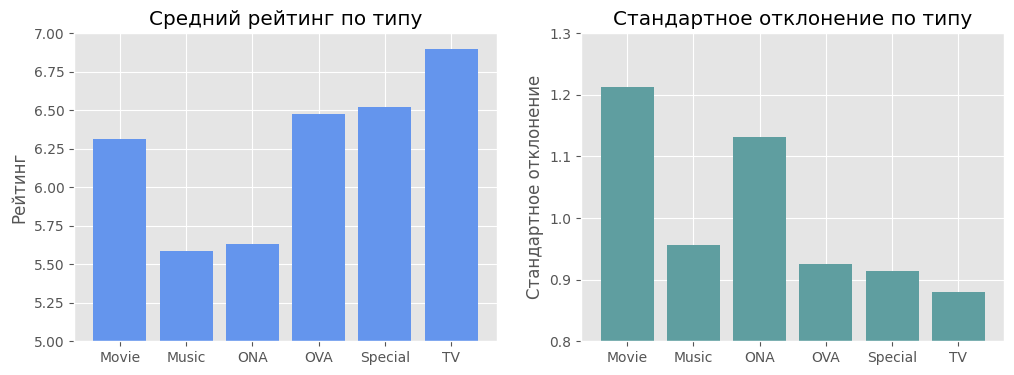

In [93]:
# Визуализация данных
plt.figure(figsize=(12, 4))

# Средний рейтинг
plt.subplot(1, 2, 1)
plt.bar(type_ratings_mean["type"], type_ratings_mean["rating"], color="cornflowerblue")
plt.title("Средний рейтинг по типу")
plt.ylabel("Рейтинг")
plt.ylim(5, 7)

# Стандартное отклонение
plt.subplot(1, 2, 2)
plt.bar(type_ratings_std["type"], type_ratings_std["rating"], color="cadetblue")
plt.title("Стандартное отклонение по типу")
plt.ylabel("Стандартное отклонение")
plt.ylim(0.8, 1.3)

plt.show()

## 3. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по жанрам. (1 балл)
График постройте для топ-15 жанров по рейтингу

In [94]:
# Группировка по жанрам и расчет среднего рейтинга и стандартного отклонения
genre_ratings = (
    df_genre_str.groupby("genre")["rating"].agg(["mean", "std"]).reset_index()
)

# Сортировка жанров по среднему рейтингу
top_15_genres = genre_ratings.sort_values("mean", ascending=False).head(15)

top_15_genres.head(3)

,genre,mean,std
11,Josei,7.447755,0.722799
36,Thriller,7.392588,1.089785
50,Josei,7.366667,1.660733


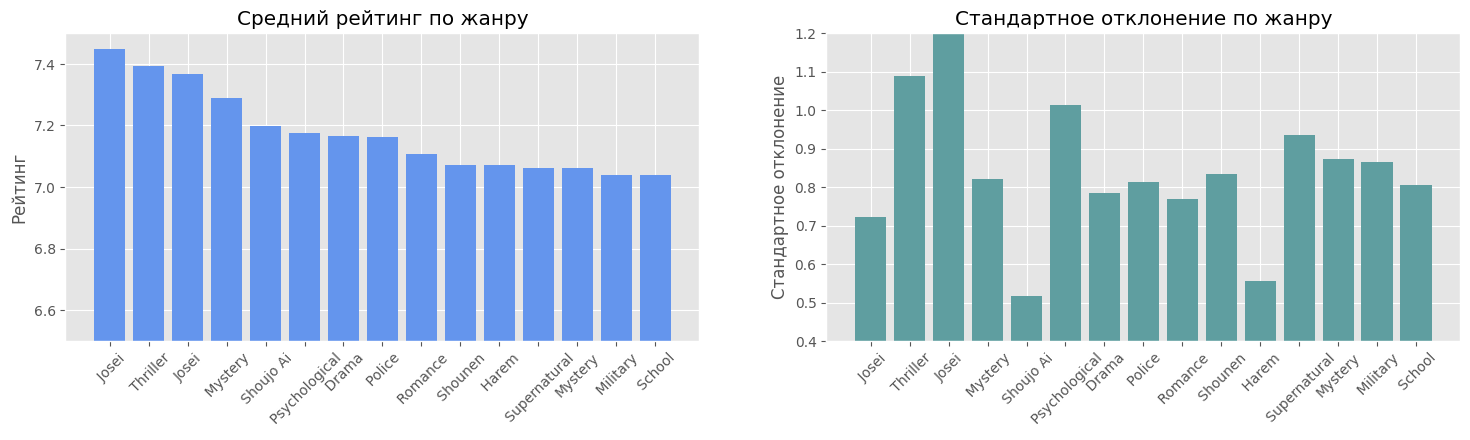

In [95]:
# Визуализация данных
plt.figure(figsize=(18, 4))

# Средний рейтинг
plt.subplot(1, 2, 1)
plt.bar(top_15_genres["genre"], top_15_genres["mean"], color="cornflowerblue")
plt.title("Средний рейтинг по жанру")
plt.ylabel("Рейтинг")
plt.xticks(rotation=45)
plt.ylim(6.5, 7.5)

# Стандартное отклонение
plt.subplot(1, 2, 2)
plt.bar(top_15_genres["genre"], top_15_genres["std"], color="cadetblue")
plt.title("Стандартное отклонение по жанру")
plt.ylabel("Стандартное отклонение")
plt.xticks(rotation=45)
plt.ylim(0.4, 1.2)

plt.show()

## 4. Посчитайте и визуализируйте квартили Q1, Q2 и Q3 с интерквантильным размахом по жанрам genre и типу аниме type. (1 балл)

## 5. Насколько часто встречаются аниме с одним или двумя жанрами? (1 балл)

In [96]:
# Подсчет уникальных жанров для каждого названия
unique_genres = df_genre_str.groupby("name")["genre"].nunique().reset_index()

# Количество аниме
count_name = unique_genres.shape[0]

In [97]:
count_genre_1 = (unique_genres["genre"] == 1).sum()
count_genre_2 = (unique_genres["genre"] == 2).sum()

print(f"Количество name с genre равным 1: {count_genre_1} из {count_name}")
print(f"Количество name с genre равным 2: {count_genre_2} из {count_name}")

Количество name с genre равным 1: 1955 из 10484
Количество name с genre равным 2: 2479 из 10484


## 6. Сколько в среднем эпизодов приходится на аниме типа == TV? (1 балл)

In [98]:
# Фильтрафия аниме типа TV
tv_series = df[df["type"] == "TV"]

# Подсчет среднего
avg_episodes_tv = tv_series["episodes"].mean()

print(f"Среднее количество эпизодов для типа == TV: {round(avg_episodes_tv)}")

Среднее количество эпизодов для типа == TV: 35


## 7. По правилу трех сигм на столбцах episodes, rating и members оцените кол-во аномалий. (1 балл)
если по одному из столбцов аниме не попадает в интервал трех сигм, то оно считается аномальным


In [99]:
# Подсчет среднего и стандартного отклонения
avg_episodes = np.mean(df["episodes"])
std_episodes = np.std(df["episodes"])

avg_rating = np.mean(df["rating"])
std_rating = np.std(df["rating"])

avg_members = np.mean(df["members"])
std_members = np.std(df["members"])

In [100]:
# Определение интервала трех сигм
lower_bound_episodes = avg_episodes - 3 * std_episodes
upper_bound_episodes = avg_episodes + 3 * std_episodes

lower_bound_rating = avg_rating - 3 * std_rating
upper_bound_rating = avg_rating + 3 * std_rating

lower_bound_members = avg_members - 3 * std_members
upper_bound_members = avg_members + 3 * std_members

In [101]:
# Фильтрация аномальных значений
anomalies_episodes = (df["episodes"] < lower_bound_episodes) | (
    df["episodes"] > upper_bound_episodes
)
anomalies_rating = (df["rating"] < lower_bound_rating) | (
    df["rating"] > upper_bound_rating
)
anomalies_members = (df["members"] < lower_bound_members) | (
    df["members"] > upper_bound_members
)

# Подсчет количества аномалий
anomalies_episodes_count = len(anomalies_episodes)
anomalies_rating_count = len(anomalies_rating)
anomalies_members_count = len(anomalies_members)

print(f"Количество аномалий в столбце episodes: {anomalies_episodes_count}")
print(f"Количество аномалий в столбце rating: {anomalies_rating_count}")
print(f"Количество аномалий в столбце members: {anomalies_members_count}")

Количество аномалий в столбце episodes: 10486
Количество аномалий в столбце rating: 10486
Количество аномалий в столбце members: 10486


## 8. Оцените и визуализируйте корреляцию среднего рейтинга жанра со средними кол-вом эпизодов и кол-вом подписчиков. (1 балл)

## 9. Оцените и визуализируйте корреляцию кол-ва жанров у аниме с его рейтингом и кол-вом подписчиков по каждому типу аниме type. (1 балл)

## 10. Оцените и визуализируйте корреляцию длины названия аниме name с его рейтингом, кол-вом жанров, эпизодов и подписчиков. (1 балл)

# 2. Часть

Каждое задание оценивается 1 баллом в случае полного выполнения

 ### Задание 11: Нормальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 элементов с нормальным распределением, где среднее  μ=5 и стандартное отклонение σ=1.5. \
Описательная статистика \
Рассчитайте выборочное среднее, выборочную медиану, выборочную моду и стандартное отклонение. \
Графическое представление \
Постройте гистограмму и график плотности распределения. Сравните выборочные статистики с теоретическими. \
Анализ отклонений \
Рассчитайте частоту значений, которые отклоняются от среднего на более чем одно стандартное отклонение, и сравните это с теоретическим результатом для нормального распределения.

In [102]:
# Генерация данных
mu = 5
sigma = 1.5

sample_norm = norm.rvs(mu, sigma, size=1000)

In [103]:
# Описательная статистика
mean_norm = np.mean(sample_norm)
median_norm = np.median(sample_norm)
mode_norm = mode(sample_norm)[0]
std_norm = np.std(sample_norm)

print(f"Выборочное среднее: {mean_norm}")
print(f"Выборочная медиана: {median_norm}")
print(f"Выборочная мода: {mode_norm}")
print(f"Выборочное стандартное отклонение: {std_norm}")

Выборочное среднее: 4.975445632482277
Выборочная медиана: 4.936606871050024
Выборочная мода: -0.06435351910977616
Выборочное стандартное отклонение: 1.535771606254789


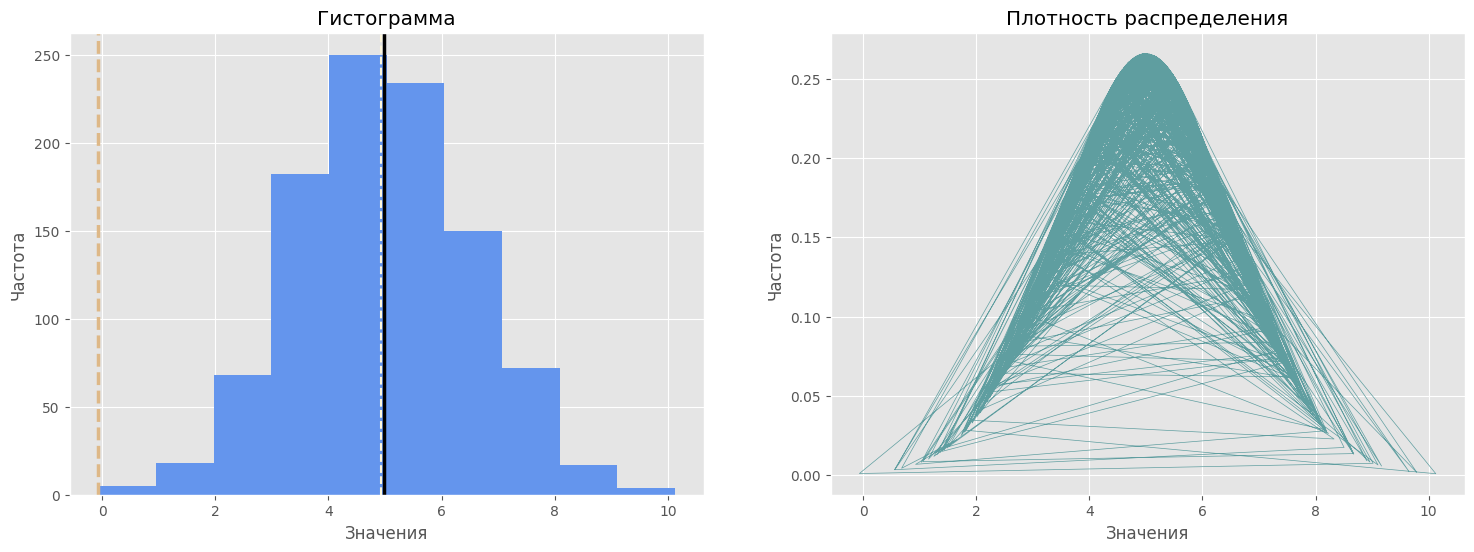

In [105]:
# Графическое представление
plt.figure(figsize=(18, 6))

# Гистограмма
plt.subplot(1, 2, 1)
plt.hist(sample_norm, bins=10, color="cornflowerblue")
plt.axvline(mean_norm, c="black", ls="-", lw=2.5)
plt.axvline(median_norm, c="cornsilk", ls="--", lw=1.5)
plt.axvline(mode_norm, c="burlywood", ls="--", lw=2.5)
plt.title("Гистограмма")
plt.xlabel("Значения")
plt.ylabel("Частота")

# Плотность распределения
plt.subplot(1, 2, 2)
plt.plot(
    sample_norm, norm.pdf(sample_norm, mu, sigma), linewidth=0.5, color="cadetblue"
)
plt.title("Плотность распределения")
plt.xlabel("Значения")
plt.ylabel("Частота")

plt.show()

In [106]:
# Анализ отклонений
sample_deviations = np.abs(sample_norm - mu) > sigma
sample_deviation_freq = np.sum(sample_deviations) / 1000

# Сравнение с теоретическим результатом
theoretical_deviation_freq = 1 - np.sqrt(2 * np.pi) * sigma * np.exp(
    -(mu**2) / (2 * sigma**2)
)

print(
    f"Частота отклонений от среднего на более чем одно стандартное отклонение: {sample_deviation_freq}"
)
print(
    f"Теоретическая частота отклонений от среднего на более чем одно стандартное отклонение: {theoretical_deviation_freq}"
)

Частота отклонений от среднего на более чем одно стандартное отклонение: 0.329
Теоретическая частота отклонений от среднего на более чем одно стандартное отклонение: 0.985464362906398


### Задание 12: Экспоненциальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 элементов из экспоненциального распределения с параметром λ=0.5. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и стандартное отклонение. \
Графическое представление \
Постройте гистограмму и график плотности распределения. \
Анализ распределения \
Определите долю значений в выборке, которые больше двух выборочных средних, и сравните это с теоретической вероятностью для экспоненциального распределения. \

In [107]:
# Генерация данных
lam = 0.5

sample_exp = expon.rvs(scale=1 / lam, size=1000)

In [108]:
# Описательная статистика
mean_exp = np.mean(sample_exp)
median_exp = np.median(sample_exp)
std_exp = np.std(sample_exp)

print(f"Выборочное среднее: {mean_exp}")
print(f"Медиана: {median_exp}")
print(f"Стандартное отклонение: {std_exp}")

Выборочное среднее: 2.017683776144438
Медиана: 1.4642668466950082
Стандартное отклонение: 1.9739879593937963


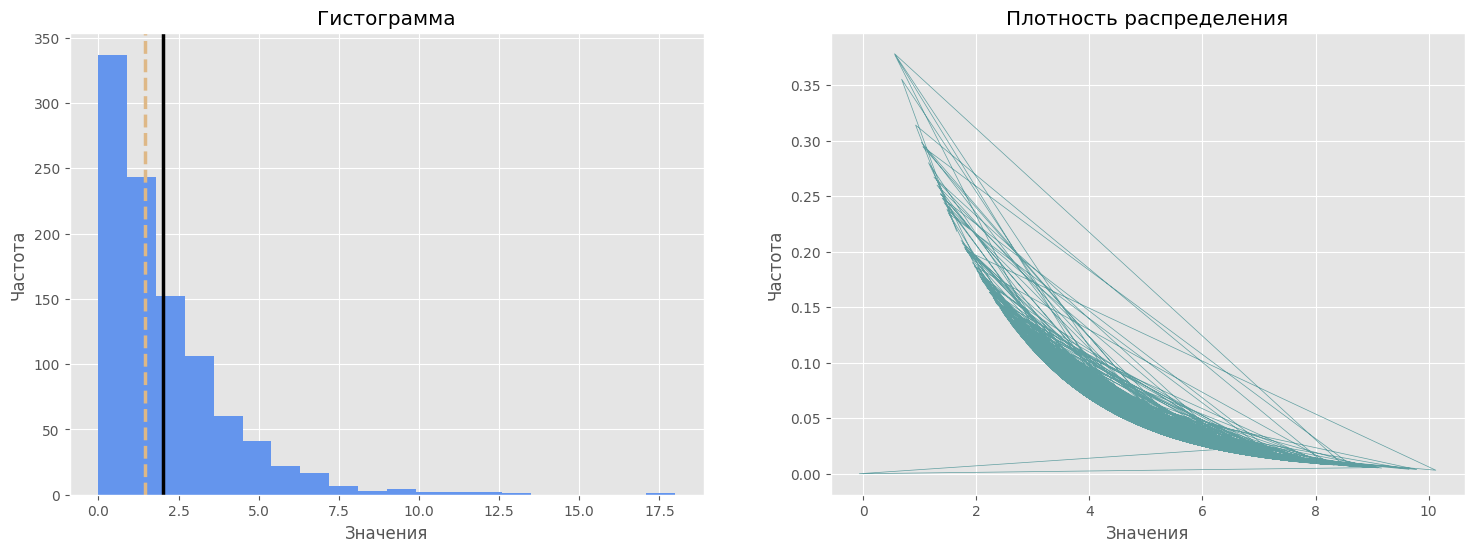

In [110]:
# Графическое представление
plt.figure(figsize=(18, 6))

# Гистограмма
plt.subplot(1, 2, 1)
plt.hist(sample_exp, bins=20, color="cornflowerblue")
plt.axvline(mean_exp, c="black", ls="-", lw=2.5)
plt.axvline(median_exp, c="burlywood", ls="--", lw=2.5)
plt.title("Гистограмма")
plt.xlabel("Значения")
plt.ylabel("Частота")

# Плотность распределения
plt.subplot(1, 2, 2)
plt.plot(
    sample_norm, expon.pdf(sample_norm, scale=1 / lam), linewidth=0.5, color="cadetblue"
)
plt.title("Плотность распределения")
plt.xlabel("Значения")
plt.ylabel("Частота")

plt.show()

In [111]:
# Анализ распределения
greater_than_mean = np.sum(sample_exp > 2 * mean_exp) / 1000
print(f"Доля значений больше двух выборочных средних: {greater_than_mean}")

# Теоретическая вероятность
theoretical_probability = 1 - np.exp(-2 * lam)
print(
    f"Теоретическая вероятность для экспоненциального распределения: {theoretical_probability}"
)

Доля значений больше двух выборочных средних: 0.129
Теоретическая вероятность для экспоненциального распределения: 0.6321205588285577



### Задание 13: Биномиальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из биномиального распределения с параметрами  n=10 и p=0.7 \
Описательная статистика \
Найдите выборочное среднее, дисперсию и моду количества успехов. \
Графическое представление \
Постройте столбчатую диаграмму распределения количества успехов. \
Анализ вероятностей \
Вычислите вероятность того, что количество успехов будет больше 8, используя как выборочные данные, так и теоретическую вероятность биномиального распределения. Сравните результаты. \

In [112]:
# Генерация данных
n = 10
p = 0.7

sample_binom = binom.rvs(n, p, size=1000)

In [113]:
# Описательная статистика
mean_binom = np.mean(sample_binom)
variance_binom = np.var(sample_binom)
mode_binom = np.bincount(sample_binom).argmax()

print("Выборочное среднее:", mean_binom)
print("Дисперсия:", variance_binom)
print("Мода:", mode_binom)

Выборочное среднее: 6.979
Дисперсия: 2.1145590000000003
Мода: 8


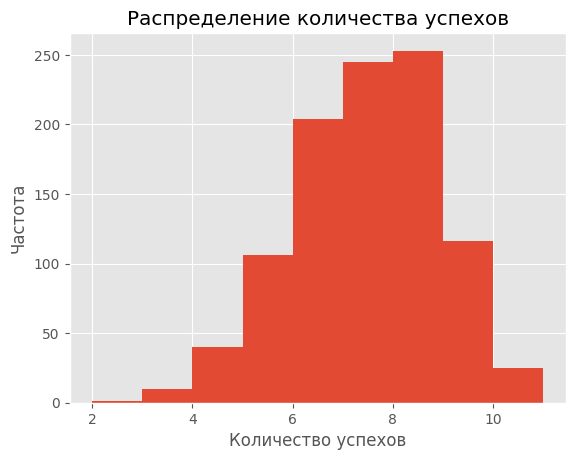

In [114]:
# Графическое представление
plt.hist(sample_binom, bins=np.arange(2, 12))
plt.title("Распределение количества успехов")
plt.xlabel("Количество успехов")
plt.ylabel("Частота")

plt.show()

In [115]:
# Анализ вероятностей
theoretical_probability = binom.pmf(8, n, p)
sample_probability = sum(sample_binom > 8) / 1000


print("Вероятность по выборке:", sample_probability)
print("Теоретическая вероятность:", theoretical_probability)

Вероятность по выборке: 0.141
Теоретическая вероятность: 0.23347444050000013


### Задание 14: Геометрическое распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из геометрического распределения с вероятностью успеха p=0.3. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и моду количества попыток до первого успеха. \
Графическое представление \
Постройте гистограмму распределения количества попыток. \
Анализ вероятностей \
Определите вероятность того, что потребуется не более 5 попыток для первого успеха, используя как выборочные данные, так и теоретическое геометрическое распределение. Сравните результаты. \

In [116]:
# Генерация данных
p = 0.3

sample_geom = geom.rvs(p, size=1000)

In [117]:
# Описательная статистика
mean_geom = np.mean(sample_geom)
median_geom = np.median(sample_geom)
mode_geom = np.bincount(sample_geom).argmax()

print(f"Выборочное среднее: {mean_geom}")
print(f"Медиана: {median_geom}")
print(f"Мода: {mode_geom}")

Выборочное среднее: 3.347
Медиана: 3.0
Мода: 1


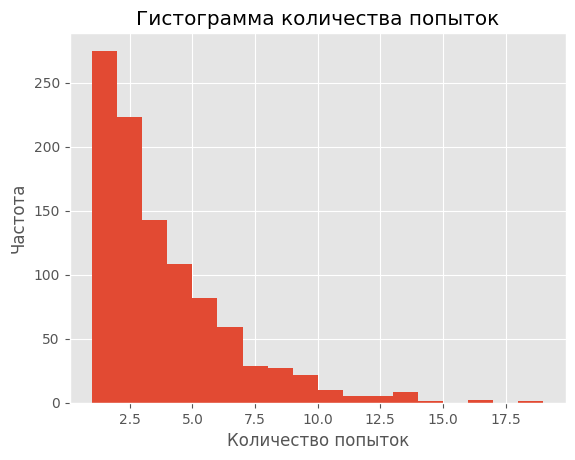

In [118]:
# Графическое представление
plt.hist(sample_geom, bins=np.arange(sample_geom.min(), sample_geom.max() + 1))
plt.title("Гистограмма количества попыток")
plt.xlabel("Количество попыток")
plt.ylabel("Частота")

plt.show()

In [119]:
# Анализ вероятностей
probability_5_attempts = sum(sample_geom <= 5) / n

# Теоретическая вероятность
theoretical_probability = p * (1 - p) ** 4

print(f"Вероятность не более 5 попыток (выборочная): {probability_5_attempts}")
print(f"Вероятность не более 5 попыток (теоретическая): {theoretical_probability}")

Вероятность не более 5 попыток (выборочная): 83.1
Вероятность не более 5 попыток (теоретическая): 0.07202999999999998


### Задание 15: Равномерное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из равномерного распределения на отрезке от 3 до 7. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и стандартное отклонение. \
Графическое представление  \
Постройте гистограмму и график плотности распределения. Сравните выборочные статистики с теоретическими значениями для равномерного распределения.
Анализ крайних значений \
Определите долю значений, которые находятся ближе к границам распределения (например, больше 6 или меньше 4), и сравните с ожидаемым результатом для равномерного распределения. \

In [124]:
# Генерация данных
sample_uni = uniform.rvs(loc=3, scale=4, size=1000)

In [125]:
# Описательная статистика
mean_uni = np.mean(sample_uni)
median_uni = np.median(sample_uni)
std_uni = np.std(sample_uni)

print(f"Выборочное среднее: {mean_uni}")
print(f"Медиана: {median_uni}")
print(f"Стандартное отклонение: {std_uni}")

Выборочное среднее: 4.964786206509282
Медиана: 4.963308155285651
Стандартное отклонение: 1.1264616482082033


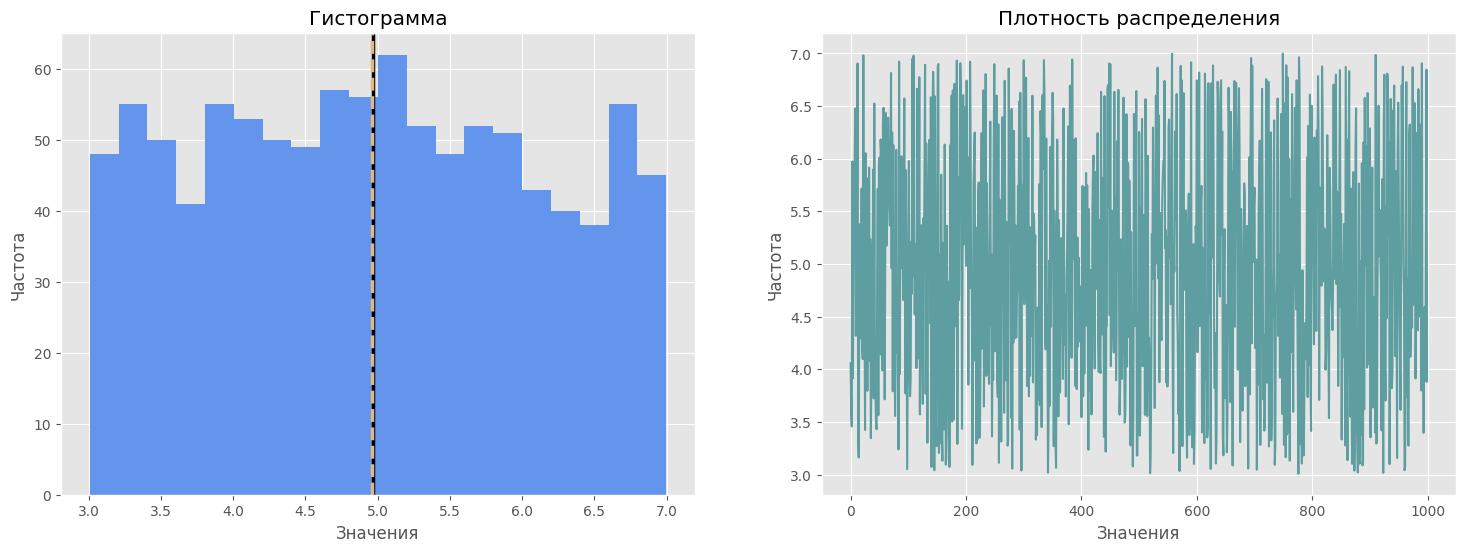

In [128]:
# Графическое представление
plt.figure(figsize=(18, 6))

# Гистограмма
plt.subplot(1, 2, 1)
plt.hist(sample_uni, bins=20, color="cornflowerblue")
plt.axvline(mean_uni, c="black", ls="-", lw=2.5)
plt.axvline(median_uni, c="burlywood", ls="--", lw=2.5)
plt.title("Гистограмма")
plt.xlabel("Значения")
plt.ylabel("Частота")

# Плотность распределения
plt.subplot(1, 2, 2)
plt.plot(sample_uni, color="cadetblue")
plt.title("Плотность распределения")
plt.xlabel("Значения")
plt.ylabel("Частота")

plt.show()

In [129]:
# Анализ крайних значений
lower_bound = 4
upper_bound = 6
lower_count = np.sum(sample_uni < lower_bound)
upper_count = np.sum(sample_uni > upper_bound)

# Теоретические значения для равномерного распределения
lower_theoretical = (lower_bound - 3) / (7 - 3)
upper_theoretical = (upper_bound - 3) / (7 - 3)

print(f"Доля значений меньше {lower_bound}: {lower_count / 1000:.2%}")
print(f"Доля значений больше {upper_bound}: {upper_count / 1000:.2%}")
print(f"Теоретическая доля значений меньше {lower_bound}: {lower_theoretical:.2%}")
print(f"Теоретическая доля значений больше {upper_bound}: {upper_theoretical:.2%}")

Доля значений меньше 4: 24.70%
Доля значений больше 6: 22.10%
Теоретическая доля значений меньше 4: 25.00%
Теоретическая доля значений больше 6: 75.00%


### Задание 16: Распределение Пуассона (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из распределения Пуассона с параметром  λ=4. \
Описательная статистика \
Найдите выборочное среднее, дисперсию и моду количества событий. \
Графическое представление \
Постройте столбчатую диаграмму распределения количества событий. \
Анализ вероятностей \
Определите вероятность того, что количество событий будет меньше 3, используя как выборочные данные, так и теоретическое распределение Пуассона. Сравните результаты. \

In [120]:
# Генерация данных
lam = 4

sample_poisson = poisson.rvs(lam, size=1000)

In [121]:
# Описательная статистика
mean_poisson = np.mean(sample_poisson)
variance_poisson = np.var(sample_poisson)
mode_poisson = np.bincount(sample_poisson).argmax()

print("Выборочное среднее:", mean_poisson)
print("Выборочная дисперсия:", variance_poisson)
print("Мода:", mode_poisson)

Выборочное среднее: 4.009
Выборочная дисперсия: 3.842919
Мода: 3


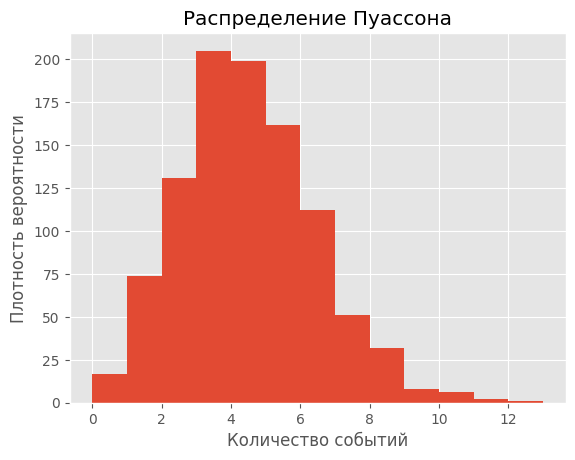

In [122]:
# Графическое представление
plt.hist(sample_poisson, bins=range(max(sample_poisson) + 1))
plt.title("Распределение Пуассона")
plt.xlabel("Количество событий")
plt.ylabel("Плотность вероятности")

plt.show()


In [123]:
# Анализ вероятностей
theoretical_prob = np.exp(-lam) * lam**2 / 2
sample_prob = sample_poisson.sum() / 1000

print("Вероятность по выборке:", sample_prob)
print("Теоретическая вероятность:", theoretical_prob)

Вероятность по выборке: 4.009
Теоретическая вероятность: 0.14652511110987343


# 3 Часть

## Задание 17: Проверка несмещённости и состоятельности выборочного среднего рейтингов (3 балла все задание)
1. Вычисление генерального среднего рейтингов \
Рассчитайте выборочное среднее рейтингов всех аниме. \
2. Проверка несмещённости оценки выборочного среднего \
Сгенерируйте 1000 выборок объёма n=100 с возвращением из исходных данных.
Для каждой выборки вычислите выборочное среднее рейтингов.
Постройте гистограмму распределения полученных выборочных средних.
Вычислите среднее из выборочных средних и сравните его с генеральным средним исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности оценки выборочного среднего. \
Повторите шаги из пункта 2 для различных объёмов выборки: n=50, 200, 500.
Для каждого объёма выборки вычислите дисперсию выборочных средних.
Постройте график зависимости дисперсии выборочных средних от объёма выборки.
Проанализируйте, как дисперсия уменьшается с увеличением объёма выборки. Сделайте вывод о состоятельности оценки. (1 балл)

## Задание 18: Проверка несмещённости и состоятельности медианы рейтингов (3 балла все задание)
1. Вычисление генеральной медианы \
Рассчитайте медиану рейтингов по всему датасету.
2. Проверка несмещённости медианы \
Сгенерируйте 1000 выборок объёма n=100 с возвращением.
Для каждой выборки вычислите медиану рейтингов.
Постройте гистограмму распределения полученных медиан.
Вычислите среднее из медиан и сравните с медианой исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности медианы \
Повторите шаги из пункта 2 для n=50, 200, 500.
Для каждого объёма выборки вычислите стандартное отклонение медиан.
Постройте график зависимости стандартного отклонения медиан от объёма выборки.
Проанализируйте изменение разброса медиан с ростом объёма выборки. Сделайте вывод о состоятельности оценки. (1 балл)

## Задание 19: Проверка несмещённости и состоятельности выборочной дисперсии рейтингов (3 балла все задание)
1. Вычисление выборочной дисперсии \
Рассчитайте выборочную дисперсию рейтингов по всему датасету.
2. Проверка несмещённости оценки выборочной дисперсии \
Сгенерируйте 1000 выборок объёма n=100 с возвращением.
Для каждой выборки вычислите выборочную дисперсию.
Постройте гистограмму распределения полученных дисперсий.
Вычислите среднее из дисперсий и сравните с выборочной дисперсией исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности оценки выборочной дисперсии \
Повторите шаги из пункта 2 для n=50, 200, 500.
Для каждого объёма выборки вычислите дисперсию оценок выборочной дисперсии.
Постройте график зависимости дисперсии оценок выборочной дисперсии от объёма выборки.
Проанализируйте изменение разброса оценок с ростом объёма выборки.  Сделайте вывод о состоятельности оценки. (1 балл)